## Import libraries

In [1]:
# libraries for data loading
import os
import json
import gzip
import pandas as pd
import numpy as np
from urllib.request import urlopen
import re
from html import unescape
import string
from textblob import TextBlob
import matplotlib.pyplot as plt


In [2]:
# libraries for text cleaning
!pip install pyspellchecker

import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import string
from spellchecker import SpellChecker

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.6 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# libraries for ML
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

## Data Loading and dataset preparation

### 1.1 Download dataset

In [7]:
# get AmazonFashion data
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/AMAZON_FASHION.json.gz
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_AMAZON_FASHION.json.gz

--2023-12-05 21:02:29--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/AMAZON_FASHION.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93185167 (89M) [application/x-gzip]
Saving to: ‘AMAZON_FASHION.json.gz’

AMAZON_FASHION.json 100%[===================>]  88.87M  82.5MB/s    in 1.1s    

2023-12-05 21:02:30 (82.5 MB/s) - ‘AMAZON_FASHION.json.gz’ saved [93185167/93185167]

--2023-12-05 21:02:30--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_AMAZON_FASHION.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33023658 (31M) [application/x-gzip]
Saving to: ‘meta_AMAZON_FASHION.json.gz’



### 1.2  Load Review dataset, basic processing
  1. keep 2016-2018's data
  2. drop irrevelant columns and handle nulls

#### 1.2.1 load data

In [8]:
# load the review data
data = []
with gzip.open('AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# total length of Meta_data
# print(f"total length of Meta_data: {len(meta_data)}")

# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)
# print(len(df_meta))

# unique asin count : total number of products
print(f"The unique asin count (total number of products): {len(df.asin.unique())}")  #186189

# check first row
print(f"first row's keys of the list: {data[0].keys()}")
print(f"first row of the list: {data[0]}")

The unique asin count (total number of products): 186189
first row's keys of the list: dict_keys(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime'])
first row of the list: {'overall': 5.0, 'verified': True, 'reviewTime': '10 20, 2014', 'reviewerID': 'A1D4G1SNUZWQOT', 'asin': '7106116521', 'reviewerName': 'Tracy', 'reviewText': 'Exactly what I needed.', 'summary': 'perfect replacements!!', 'unixReviewTime': 1413763200}


In [9]:
df.head(10)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN
5,5.0,True,"07 19, 2014",A29HLOUW0NS0EH,7106116521,Patricia R. Erwin,Exactly what I wanted.,Five Stars,1405728000,NaN,NaN,NaN
6,4.0,True,"05 31, 2014",A7QS961ROI6E0,7106116521,REBECCA S LAYTON,These little plastic backs work great. No mor...,Works great!,1401494400,NaN,NaN,NaN
7,3.0,True,"09 22, 2013",A1BB77SEBQT8VX,B00007GDFV,Darrow H Ankrum II,mother - in - law wanted it as a present for h...,bought as a present,1379808000,NaN,{'Color:': ' Black'},NaN
8,3.0,True,"07 17, 2013",AHWOW7D1ABO9C,B00007GDFV,rosieO,"Item is of good quality. Looks great, too. But...",Buxton heiress collection,1374019200,NaN,{'Color:': ' Black'},NaN
9,3.0,True,"04 13, 2013",AKS3GULZE0HFC,B00007GDFV,M. Waltman,I had used my last el-cheapo fake leather ciga...,Top Clasp Broke Within 3 days!,1365811200,NaN,{'Color:': ' Black'},NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         883636 non-null  float64
 1   verified        883636 non-null  bool   
 2   reviewTime      883636 non-null  object 
 3   reviewerID      883636 non-null  object 
 4   asin            883636 non-null  object 
 5   reviewerName    883544 non-null  object 
 6   reviewText      882403 non-null  object 
 7   summary         883103 non-null  object 
 8   unixReviewTime  883636 non-null  int64  
 9   vote            79900 non-null   object 
 10  style           304569 non-null  object 
 11  image           28807 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 75.0+ MB


#### 1.2.2 Cut newest 1 year's data (2018)
 1. tried to keep newest 3 years (2016-2018), dataset still too large (original length: 883636, 3 years length: 545725)
 2. tried to keep only 2018's data --- 58024 reviews left

In [11]:
# use 'reviewTime column in Review data" -----eg:  "reviewTime": "01 1, 2018"

# convert 'reviewTime' to datetime
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

# filter the DataFrame to keep only rows from 2018
filtered_df = df[df['reviewTime'].dt.year.isin([2018])]

filtered_df.sample(5)




,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
755440,1.0,True,2018-01-02,A164O8MNAI6IFC,B018LW34N8,DallasGal11,"Do not buy these, after a few uses it falls ap...",One Star,1514851200,NaN,{'Color:': ' Yellow'},NaN
752289,3.0,True,2018-03-21,A2AQ4QRB8KKG4E,B017TBW7XU,Amazon Customer,Size runs small ordered a medium should of got...,Three Stars,1521590400,NaN,NaN,NaN
295582,5.0,True,2018-02-17,A1Z4HFY4DOQH28,B010NDJFYA,Elba E. Barreto,In these photos it is not completely closed si...,Perfect! Just what I was dreaming,1518825600,NaN,"{'Size:': ' Medium', 'Color:': ' Red'}",[https://images-na.ssl-images-amazon.com/image...
602665,5.0,True,2018-07-14,A3SBK2J0TV2UOK,B00T11WFQ6,Lynne,Love this suit fit as it should,Good quality and good fit,1531526400,NaN,"{'Size:': ' 16', 'Color:': ' Brown'}",NaN
695449,1.0,True,2018-02-07,A15P0JR2QCZIUN,B014D4MYCU,Sutton,It is stringy and it sucks,One Star,1517961600,NaN,NaN,NaN


In [12]:

print(f"original length: {len(df)}")
print(f"2018 year's length: {len(filtered_df)}")

df = filtered_df


original length: 883636
2018 year's length: 58024


#### 1.2.3 Drop columns and some null valus

In [13]:
# drop image, vote, style, reviewName, reviewTime columns
columns_to_drop2 = ['image', 'vote', 'style', 'reviewerName', 'unixReviewTime', 'verified', 'reviewerID']
df = df.drop(columns=columns_to_drop2)

In [14]:
# drop null values acoording to asin and overall column
essential_columns2 = ['overall', 'asin', 'reviewText']
df = df.dropna(subset=essential_columns2)

df.head(10)

,overall,reviewTime,asin,reviewText,summary
994,5.0,2018-01-02,B00066G516,Just what I needed for a party,Five Stars
1893,4.0,2018-03-13,B0008F6WMM,Son loves it. Decent quality.,Four Stars
1894,5.0,2018-02-27,B0008F6WMM,My son wanted to dress like August Pullman fro...,"Cute, sounds are great, well made"
1895,5.0,2018-02-22,B0008F6WMM,awesome.,Five Stars
1896,5.0,2018-02-11,B0008F6WMM,My daughter loves this item. My high score is ...,Child loves it!
1897,5.0,2018-01-19,B0008F6WMM,My son has Autism and when he seen the movie W...,LOVE LOVE!!!!!!!!
1898,5.0,2018-01-07,B0008F6WMM,Bought this for my godson - he absolutely love...,Great purchase!!
1899,5.0,2018-01-06,B0008F6WMM,This helmet was a HIT!!! The 'countdown' audi...,The 'countdown' audio is fantastic and the hel...
1900,5.0,2018-01-04,B0008F6WMM,This is a great toy! I am a kid and I love thi...,This is a great toy! I am a kid and I love ...
1901,5.0,2018-01-04,B0008F6WMM,8 year old son LOVES this helmet. It was top ...,Five Stars


### 1.3 Load Meta data and basic processing
    1. drop useless columns and handle null values
    2. only keep ASINs which are in the Review dataset
    3. Clean rank column and create a new category column
    4. clean title columns (given code)


#### 1.3.1 load data

In [15]:
### load the meta data
meta_data = []
with gzip.open('meta_AMAZON_FASHION.json.gz') as f:
    for l in f:
        meta_data.append(json.loads(l.strip()))

# total length of Meta_data
# print(f"total length of Meta_data: {len(meta_data)}")

# convert list into pandas dataframe
df_meta = pd.DataFrame.from_dict(meta_data)
# print(len(df_meta))

# unique asin count : total number of products
print(f"The unique asin count (total number of products): {len(df_meta.asin.unique())}")  #186194

# check first row
print(f"first row's keys of the list: {meta_data[0].keys()}")
print(f"first row of the list: {meta_data[0]}")

The unique asin count (total number of products): 186194
first row's keys of the list: dict_keys(['title', 'brand', 'feature', 'rank', 'date', 'asin', 'imageURL', 'imageURLHighRes'])
first row of the list: {'title': 'Slime Time Fall Fest [With CDROM and Collector Cards and Neutron Balls, Incredi-Ball and Glow Stick Necklace, Paper Fram', 'brand': 'Group Publishing (CO)', 'feature': ['Product Dimensions:\n                    \n8.7 x 3.6 x 11.4 inches', 'Shipping Weight:\n                    \n2.4 pounds'], 'rank': '13,052,976inClothing,Shoesamp;Jewelry(', 'date': '8.70 inches', 'asin': '0764443682', 'imageURL': ['https://images-na.ssl-images-amazon.com/images/I/51bSrINiWpL._US40_.jpg'], 'imageURLHighRes': ['https://images-na.ssl-images-amazon.com/images/I/51bSrINiWpL.jpg']}


In [16]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186637 entries, 0 to 186636
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            186632 non-null  object
 1   brand            139957 non-null  object
 2   feature          123875 non-null  object
 3   rank             180222 non-null  object
 4   date             185001 non-null  object
 5   asin             186637 non-null  object
 6   imageURL         132017 non-null  object
 7   imageURLHighRes  132017 non-null  object
 8   description      15869 non-null   object
 9   price            17799 non-null   object
 10  also_view        11595 non-null   object
 11  also_buy         21642 non-null   object
 12  fit              4831 non-null    object
 13  details          885 non-null     object
 14  similar_item     317 non-null     object
 15  tech1            97 non-null      object
dtypes: object(16)
memory usage: 22.8+ MB


In [17]:
df_meta.head(10)

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XCC Qi promise new spider snake preparing men'...,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Magical Things I Really Do Do Too!,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[For the professional or amateur magician. Ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Ashes to Ashes, Oranges to Oranges",Flickerlamp Publishing,[Package Dimensions:\n \n8....,"19,734,184inClothing,ShoesJewelry(",5 star,1940735033,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aether & Empire #1 - 2016 First Printing Comic...,NaN,[Package Dimensions:\n \n10...,"10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,$4.50,NaN,NaN,NaN,NaN,NaN,NaN
5,"365 Affirmations for a Year of Love, Peace & P...",NaN,NaN,"16,179,013inClothing,Shoesamp;Jewelry(",5 star,1942705034,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Blessed by Pope Benedetto XVI Wood Religious B...,NaN,[Package Dimensions:\n \n4....,"7,787,039inClothing,ShoesJewelry(",5 star,3293015344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Womens Sexy Sleeveless Camouflage Print Casual...,Didala,[Package Dimensions:\n \n8....,"9,854,284inClothing,ShoesJewelry(",5 star,5378828716,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Sevendayz Men's Shady Records Eminem Hoodie Ho...,sevendayz,NaN,"16,147,550inClothing,Shoesamp;Jewelry(",5 star,6041002984,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Dante's Peak - Laserdisc,NaN,[Package Dimensions:\n \n12...,"16,714,561inClothing,ShoesJewelry(",5 star,630456984X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_meta.date.unique()

# confused about this column

array(['8.70 inches', '5 star', 'fishhook', ..., 'Harley Quinn', 'YA210',
       'IK COLOURING'], dtype=object)

#### 1.3.2 drop columns, drop some null values

In [19]:
# drop imageURL, imageURLHIghRes, tech1, similar_item, fit, feature
columns_to_drop = ['imageURL', 'imageURLHighRes', 'tech1', 'similar_item', 'price',
                   'fit', 'also_view', 'also_buy', 'details', 'feature', 'date', 'description']  # replace with actual column names
df_meta = df_meta.drop(columns=columns_to_drop)


In [20]:
# drop null values according to asin column
essential_columns = ['asin']
df_meta = df_meta.dropna(subset=essential_columns)


In [21]:
# check some column
df_meta.head(10)

,title,brand,rank,asin
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),"13,052,976inClothing,Shoesamp;Jewelry(",0764443682
1,XCC Qi promise new spider snake preparing men'...,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",1291691480
2,Magical Things I Really Do Do Too!,Christopher Manos,"19,308,073inClothing,ShoesJewelry(",1940280001
3,"Ashes to Ashes, Oranges to Oranges",Flickerlamp Publishing,"19,734,184inClothing,ShoesJewelry(",1940735033
4,Aether & Empire #1 - 2016 First Printing Comic...,NaN,"10,558,646inClothing,Shoesamp;Jewelry(",1940967805
5,"365 Affirmations for a Year of Love, Peace & P...",NaN,"16,179,013inClothing,Shoesamp;Jewelry(",1942705034
6,Blessed by Pope Benedetto XVI Wood Religious B...,NaN,"7,787,039inClothing,ShoesJewelry(",3293015344
7,Womens Sexy Sleeveless Camouflage Print Casual...,Didala,"9,854,284inClothing,ShoesJewelry(",5378828716
8,Sevendayz Men's Shady Records Eminem Hoodie Ho...,sevendayz,"16,147,550inClothing,Shoesamp;Jewelry(",6041002984
9,Dante's Peak - Laserdisc,NaN,"16,714,561inClothing,ShoesJewelry(",630456984X


In [22]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186637 entries, 0 to 186636
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   186632 non-null  object
 1   brand   139957 non-null  object
 2   rank    180222 non-null  object
 3   asin    186637 non-null  object
dtypes: object(4)
memory usage: 5.7+ MB


#### 1.3.3 Remove data that their ASINs are not in the Review dataset

In [23]:
# Meta and Review data's unique ASIN check  --
print(f"Unique asin count in review data: {len(df.asin.unique())}")   #16129
print(f"Unique asin count in meta data: {len(df_meta.asin.unique())}") # 185764

# Keep only the rows in df2 where 'asin' exists in df1
filtered_df_meta = df_meta[df_meta['asin'].isin(df['asin'])]

Unique asin count in review data: 16134
Unique asin count in meta data: 186194


In [24]:
# check filter result
print(f"length of filtered df meta: {len(filtered_df_meta)}")

print(f"Unique asin count in filtered meta data: {len(filtered_df_meta.asin.unique())}") # 16134

length of filtered df meta: 16145
Unique asin count in filtered meta data: 16134


In [25]:
# check unmatched ASIN
meta_asin = list(filtered_df_meta.asin.unique())
review_asin = list(df.asin.unique())

c=0
for i in review_asin:
    if i not in meta_asin:
        c+=1
print(c)

0


In [26]:
df_meta = filtered_df_meta

df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16145 entries, 7 to 186635
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   16144 non-null  object
 1   brand   12294 non-null  object
 2   rank    15673 non-null  object
 3   asin    16145 non-null  object
dtypes: object(4)
memory usage: 630.7+ KB


#### 1.3.4 Clean Rank column, create new category column

In [27]:
# In rank column, check categories and crate a new category column ---- 34 categories

# Function to extract category from the rank string
def extract_category(rank):
    if pd.isnull(rank) or not isinstance(rank, str):
        return None
    match = re.search(r'in(.+?)\(', rank)
    return match.group(1) if match else None

# Extract category and create a new column for it
df_meta['category'] = df_meta['rank'].apply(extract_category)

# Count unique categories
num_unique_categories = df_meta['category'].nunique()

print(num_unique_categories)   # 20

20


In [28]:
# show 20 categories
df_meta.category.unique()

array(['Clothing,ShoesJewelry', 'Clothing,Shoesamp;Jewelry', None,
       'SportsOutdoors', ' Home & Kitchen ', ' Arts, Crafts & Sewing ',
       ' Toys & Games ', ' Office Products ', 'HealthHousehold',
       'BeautyPersonalCare', ' Tools & Home Improvement ',
       'IndustrialScientific', 'Books', ' Kitchen & Dining ',
       'AmazonLaunchpad', 'Electronics', 'Baby', ' Automotive ',
       'CellPhonesAccessories', 'Arts,CraftsSewing', 'HomeKitchen'],
      dtype=object)

In [29]:
# further clean rank column and only keep number in rank column
def clean_rank(rank):
    if pd.isnull(rank) or not isinstance(rank, str):
        return None
    # Extract numerical part and remove commas
    rank_clean = re.sub(r'[^0-9]', '', rank)
    # Convert to integer
    try:
        return int(rank_clean)
    except ValueError:
        return None  # or a default value

# Clean the rank column
df_meta['rank'] = df_meta['rank'].apply(clean_rank)

# Handle missing values (optional, based on your preference)
# df = df.dropna(subset=['rank'])  # Option 1: Drop rows with missing rank
# df['rank'].fillna(df['rank'].median(), inplace=True)  # Option 2: Fill with median

df_meta.head(10)

,title,brand,rank,asin,category
7,Womens Sexy Sleeveless Camouflage Print Casual...,Didala,9854284.0,5378828716,"Clothing,ShoesJewelry"
18,Shimmer Anne Shine Clip On Costume/Halloween C...,Shimmer Anne Shine,468314.0,B00004T3SN,"Clothing,ShoesJewelry"
69,Buxton Heiress Pik-Me-Up Framed Case,Buxton,43930.0,B00007GDFV,"Clothing,Shoesamp;Jewelry"
80,Paul Fredrick Men's Pinpoint Varsity Spread Fr...,NaN,7289805.0,B00008JQLL,"Clothing,ShoesJewelry"
81,Paul Fredrick Men's Pinpoint Snap Tab Collar B...,NaN,6123960.0,B00008JPRZ,"Clothing,Shoesamp;Jewelry"
82,Paul Fredrick Men's Pinpoint Snap Tab Collar F...,NaN,4785781.0,B00008JVTT,"Clothing,ShoesJewelry"
83,Paul Fredrick Men's Pinpoint Windsor Spread Co...,NaN,5555691.0,B00008JRUJ,"Clothing,ShoesJewelry"
84,Paul Fredrick Men's Pinpoint Straight Collar B...,NaN,3976061.0,B00008JQF0,"Clothing,ShoesJewelry"
89,Paul Fredrick Men's Pinpoint Button Down Colla...,NaN,3904648.0,B00008JOQI,"Clothing,ShoesJewelry"
232,Freddy vs. Jason Glove & Mask Set,NECA,9619903.0,B0000ZG44Q,"Clothing,ShoesJewelry"


In [30]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16145 entries, 7 to 186635
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     16144 non-null  object 
 1   brand     12294 non-null  object 
 2   rank      15601 non-null  float64
 3   asin      16145 non-null  object 
 4   category  15601 non-null  object 
dtypes: float64(1), object(4)
memory usage: 756.8+ KB


#### 1.3.6 Clean Title column (contains unformatted title such as 'getTime')

In [31]:
### In title column, remove rows with unformatted title (i.e. some 'title' may still contain html style content)
df3 = df_meta.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
df5 = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print(len(df4))
print(len(df5))

44
16101


In [32]:
# how those unformatted rows look like
df4.iloc[0]

title       var aPageStart = (new Date()).getTime();\nvar ...
brand                                                  SPERRY
rank                                                  32911.0
asin                                               B0014A6GU8
category                                Clothing,ShoesJewelry
Name: 4286, dtype: object

In [33]:
# df5.head(10)
df_meta = df5
df_meta.head(10)


,title,brand,rank,asin,category
7,Womens Sexy Sleeveless Camouflage Print Casual...,Didala,9854284.0,5378828716,"Clothing,ShoesJewelry"
18,Shimmer Anne Shine Clip On Costume/Halloween C...,Shimmer Anne Shine,468314.0,B00004T3SN,"Clothing,ShoesJewelry"
69,Buxton Heiress Pik-Me-Up Framed Case,Buxton,43930.0,B00007GDFV,"Clothing,Shoesamp;Jewelry"
80,Paul Fredrick Men's Pinpoint Varsity Spread Fr...,,7289805.0,B00008JQLL,"Clothing,ShoesJewelry"
81,Paul Fredrick Men's Pinpoint Snap Tab Collar B...,,6123960.0,B00008JPRZ,"Clothing,Shoesamp;Jewelry"
82,Paul Fredrick Men's Pinpoint Snap Tab Collar F...,,4785781.0,B00008JVTT,"Clothing,ShoesJewelry"
83,Paul Fredrick Men's Pinpoint Windsor Spread Co...,,5555691.0,B00008JRUJ,"Clothing,ShoesJewelry"
84,Paul Fredrick Men's Pinpoint Straight Collar B...,,3976061.0,B00008JQF0,"Clothing,ShoesJewelry"
89,Paul Fredrick Men's Pinpoint Button Down Colla...,,3904648.0,B00008JOQI,"Clothing,ShoesJewelry"
232,Freddy vs. Jason Glove & Mask Set,NECA,9619903.0,B0000ZG44Q,"Clothing,ShoesJewelry"


### 1.4 Join review dataset and meta dataset on ASIN  - merged_df

In [35]:
merged_df = pd.merge(df, df_meta, on='asin', how='inner')

In [37]:
merged_df.head(5)

,overall,reviewTime,asin,reviewText,summary,title,brand,rank,category
0,5.0,2018-01-02,B00066G516,Just what I needed for a party,Five Stars,Leg Avenue Women's Lace Ruffle Anklet Socks,,32865.0,"Clothing,ShoesJewelry"
1,5.0,2018-05-15,B00066G516,Just tight. These socks stayed in place well. ...,Five Stars,Leg Avenue Women's Lace Ruffle Anklet Socks,,32865.0,"Clothing,ShoesJewelry"
2,5.0,2018-04-23,B00066G516,"Super cute and comfortable. I wear a size 11, ...",Cute and comfy,Leg Avenue Women's Lace Ruffle Anklet Socks,,32865.0,"Clothing,ShoesJewelry"
3,5.0,2018-04-08,B00066G516,These are great. Perfectly fit my rather larg...,Great buy,Leg Avenue Women's Lace Ruffle Anklet Socks,,32865.0,"Clothing,ShoesJewelry"
4,3.0,2018-04-04,B00066G516,"I love the large ruffle on the sock, however I...",They don't cover ankles and I believe they wil...,Leg Avenue Women's Lace Ruffle Anklet Socks,,32865.0,"Clothing,ShoesJewelry"


In [39]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57397 entries, 0 to 57396
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   overall     57397 non-null  float64       
 1   reviewTime  57397 non-null  datetime64[ns]
 2   asin        57397 non-null  object        
 3   reviewText  57397 non-null  object        
 4   summary     57365 non-null  object        
 5   title       57397 non-null  object        
 6   brand       57397 non-null  object        
 7   rank        57397 non-null  object        
 8   category    57397 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 4.4+ MB


In [44]:
merged_df.brand.sample(10)
# brand column contains many ' ' empty string

20695                         
54564                FORBUSITE
38182    Yoga by Epic MMA Gear
13362                   Walker
49392                   Qianle
7589         MJ Metals Jewelry
33965              boxed-gifts
26064                Viottiset
21281            SERMAN BRANDS
44748             Vital Nation
Name: brand, dtype: object

# Task1: reviewText sentiment classification -- model performance comparasion

## 0.  Text cleaning for review.reviewText column

no need to reclean the data, it's already saved in google drive as a csv file (cleaning takes around 45 mins)

In [45]:
data = merged_df

In [46]:
data['reviewText'].sample(30)
# has URL
# many stopwords
# lengths differ significantly (some reviews only haave one or two words)
# need to expand contractions (XXX not):
        # don't,
        # doesn't
        # wouldn't
        # didn't
        # can't
        # wasn't

# sometimes reviewers use ! or !!! to express strong sentiment, do not remove !
# interesting negative expression in review context?
        # eg: too small? --negative
        # joke:-- negative
        # ok... -- negative
# reviews focus on different aspects, such as: fit(size), color, quality.... might need to be categorized?
# has HTML format like this: <div id="video-block-R2O5OQ6TK8Z02F" class="a-...

4200     This is a fitted body suit, but based upon pre...
22856                    beautiful red and comfortable fit
20454                                           Fits great
9433     The material was paper thin...I don't like bei...
1611     I buy these every 6-9 months. These are the be...
51404    Very flattering.  I bought one in black and on...
39422                      Love this suit fit as it should
43096    The shirt was extremely small and i had to giv...
867      I like these but they could use a little more ...
29312    Fits great and is comfortable. I wear a 34C br...
12424                                Exactly what I wanted
50053    The product was here very fast and am very ple...
51759    We both love this Polo, one of my favorites on...
16558    My granddaughter was very happy with her bathi...
27883    This belt made me forsake formal belts. One si...
50006    Durable pair of sunglasses. Got ran over durin...
14687    This mask was exactly what I was looking for. .

In [4]:
# Expand contractions

# define our contractions dictionary
contractions_dict = {"can't": "cannot",
                     "couldn't": "could not",
                     "don't": "do not",
                     "doesn't": "does not",
                     "didn't": "did not",
                     "wasn't": "was not",
                     "weren't": "were not",
                     "wouldn't": "would not",
                     "won't": "will not"}

# expand contractions
def expand_contractions(text, contractions=contractions_dict):
    for word in contractions:
        text = text.replace(word, contractions[word])
    return text



In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
spell = SpellChecker()

# Function to clean text
def clean_review_text(text):
    '''clean a reviewText and return a list of cleaned words'''
    # remove HTML-like content using regular expressions
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[\w-]+="[\w-]+"', '', text)  # Remove attributes
    # remove URLs and file paths
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\S+\.(jpg|png|gif|jpeg|mp4|avi)', '', text)
    # lowercasing
    text = text.lower()
    # handling Unicode characters
    text = text.encode('ascii', 'ignore').decode()
    # expand Contractions
    text = expand_contractions(text)
    # remove special characters, punctuations except for exclamation marks
    text = re.sub(r'[^a-z0-9\s!]', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # tokenization
    words = word_tokenize(text)
    # eliminate stopwords and apply lemmatization
    cleaned_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # correct spelling
    cleaned_text = [spell.correction(word) for word in cleaned_text]
    joined_text = ' '.join(word for word in cleaned_text if word is not None)
    return joined_text

In [82]:
# Check cleaning result on a small sample
sample = data['reviewText'].sample(10)
sample.apply(clean_review_text)

55589          fabric shirt itchy uncomfortable flattering
15955    cheaply made ! bother buying one look make obv...
12208                                      girlfriend love
32487    got wear pant flight attendant leg compression...
12617                                                 love
16735    fit great comfortable look great im nice suit ...
41214    love glove small wear medium dress glove get t...
32025                                                 cute
25206    ordered size pim la set cute comfortable might...
14242              love bag use everyday never disappoints
Name: reviewText, dtype: object

In [83]:
# clean review.reviewText data and created as a new column 'cleaned_reviewText'

# original dataset, running more than 40 minutes on GPU --- we need to cut data -- cutted
data['cleaned_reviewText'] = data['reviewText'].apply(clean_review_text)

In [92]:
#check result
# data = data.drop('cleaned_reviewText_string', axis=1)
data.sample(10)

,overall,reviewTime,asin,reviewText,summary,title,brand,rank,category,cleaned_reviewText
57170,5.0,2018-06-29,B01HDIILB6,Goes with every outfit an they aren't so heavy!,Five Stars,Mystic Metals Body Jewelry Embedded Real White...,Mystic Metals Body Jewelry,290261.0,"Clothing,ShoesJewelry",go every outfit arent heavy !
10434,5.0,2018-07-30,B00NCO2U40,"Great quality, all the right sizes, and all th...","Great quality, all the right sizes",PiercingJ 14pcs 12G-00G Uv Acrylic Spiral Snai...,PiercingJ,377493.0,"Clothing,ShoesJewelry",great quality right size pair sent hair get ca...
3908,3.0,2018-02-21,B0015V8KN2,They look so cute. Was very dissapointed that ...,Three Stars,Bearington Baby Soft Plush Stuffed Animal Sock...,Bearington Collection,27157.0,"Clothing,ShoesJewelry",look cute dissapointed fit son thats
30141,5.0,2018-03-02,B01G5VFO58,"I really like these, they hold everything real...",Finding underwear being able to hold all my junk.,Fruit of the Loom Men's Breathable Brief Multi...,NaN,9076.0,"Clothing,ShoesJewelry",really like hold everything really well troubl...
3901,5.0,2018-03-20,B0015V8KN2,Very soft and cuddly. Baby will love looking a...,Baby will love looking at them as she kicks,Bearington Baby Soft Plush Stuffed Animal Sock...,Bearington Collection,27157.0,"Clothing,ShoesJewelry",soft cuddly baby love looking kick
21228,3.0,2018-06-02,B016X7JSNS,"Nice suit, but the suit size 40S/34 waist does...",Size..smaller than said size,P&L Men's Premium Slim Fit 2-Piece Suit Blazer...,P&L,42034.0,"Clothing,ShoesJewelry",nice suit suit size waist doesn't match waist ...
21851,5.0,2018-07-01,B017LJPBWO,Perfect great quality true to length,Five Stars,WAJY Lace Edge Cathedral Length Long Bridal We...,WAJY,873800.0,"Clothing,ShoesJewelry",perfect great quality true length
6711,5.0,2018-02-20,B00DH6LY90,gift,Five Stars,Thin Metal Frame Heart Shape Sunglasses Gold/S...,JuicyOrange,246175.0,"Clothing,ShoesJewelry",gift
3464,5.0,2018-03-22,B000YFSR4W,I liked that it fit my husband. The length of ...,I liked that it fit my husband,Hanes Mens EcoSmart Fleece Sweatpant,NaN,13395.0,"Clothing,ShoesJewelry",liked fit husband length pant also good soft c...
22789,5.0,2018-08-21,B018IZAYEU,Im small and have a short torso. It a little l...,Overall happy with my purchase,Fajate 9002 Post Surgery Abdominal Compression...,Fajate Virtual Sensuality,23981.0,"Clothing,ShoesJewelry",im small short torso little large take time le...


In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57397 entries, 0 to 57396
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   overall             57397 non-null  float64
 1   reviewTime          57397 non-null  object 
 2   asin                57397 non-null  object 
 3   reviewText          57397 non-null  object 
 4   summary             57365 non-null  object 
 5   title               57394 non-null  object 
 6   brand               41206 non-null  object 
 7   rank                55306 non-null  float64
 8   category            55306 non-null  object 
 9   cleaned_reviewText  57397 non-null  object 
dtypes: float64(2), object(8)
memory usage: 4.4+ MB


#### Save and download cleaned data (cleaning process takes 40+ mins, no need to clean again)

In [94]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
data.to_csv('/content/drive/My Drive/cleaned_data.csv', index=False)
data.to_csv('cleaned_data.csv', index=False)

In [96]:
from google.colab import files

# Download the file
files.download('/content/drive/My Drive/cleaned_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Start from here, we used the saved cleaned_data file - can start to run code from here

In [6]:
# give this notebook access to drive files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
path = '/content/drive/My Drive/cleaned_data.csv'
data = pd.read_csv(path)
data.sample(5)

,overall,reviewTime,asin,reviewText,summary,title,brand,rank,category,cleaned_reviewText
34152,5.0,2018-03-27,B00DGGEU38,Great fit and look for a medieval wedding I at...,Great Fit.,Costume Culture Women's Barbarian Warrior Costume,Costume Culture,158177.0,"Clothing,ShoesJewelry",great fit look medieval wedding attended
26261,3.0,2018-01-08,B01CUACR8K,"material is weird, but cute fit",Three Stars,Dearlovers Women Wide Leg Loose Fit Belted Jum...,Dearlovers,1348092.0,"Clothing,ShoesJewelry",material weird cute fit
7598,5.0,2018-06-08,B00G8Q7JZ4,Bought 10mm and 6mm.\nBoth excellent,Great,MJ Metals Jewelry 2mm to 10mm White Tungsten C...,MJ Metals Jewelry,8871.0,"Clothing,ShoesJewelry",bought my my excellent
15209,5.0,2018-04-20,B00XT15P8E,Simple. Nice. Fully satisfied.,Nice. Fully satisfied,Marino Avenue Men’s Genuine Leather Ratchet Dr...,NaN,2159.0,"Clothing,ShoesJewelry",simple nice fully satisfied
50135,5.0,2018-04-25,B01BI7W8Q2,Love these sweatshirts this is my second one a...,Love these sweatshirts,SafetyShirtz SS360 Seattle Safety Hoody ANSI C...,SafetyShirtz,310828.0,"Clothing,ShoesJewelry",love sweatshirt second one also backwoods camo...


In [8]:
data.cleaned_reviewText.sample(10)

39531    even better expected hold every thing take cru...
44269                                 ordered i size order
1417                                          good product
13198                           bought gift husband love !
7283     light flimsy plastic super dark emulate look e...
21658    first pair badly sewn liner left glove could g...
18106                                     love perfect fit
56457         sweet gift daughter love blow thing one keep
23809    one size fit gamble pleasantly surprised fit a...
8506     legging amazing ! ! provide enough compression...
Name: cleaned_reviewText, dtype: object

In [9]:
data['cleaned_reviewText'].isnull().sum()

114

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57397 entries, 0 to 57396
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   overall             57397 non-null  float64
 1   reviewTime          57397 non-null  object 
 2   asin                57397 non-null  object 
 3   reviewText          57397 non-null  object 
 4   summary             57365 non-null  object 
 5   title               57394 non-null  object 
 6   brand               41206 non-null  object 
 7   rank                55306 non-null  float64
 8   category            55306 non-null  object 
 9   cleaned_reviewText  57283 non-null  object 
dtypes: float64(2), object(8)
memory usage: 4.4+ MB


In [11]:
# remove null values
data = data.dropna(subset=['cleaned_reviewText'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57283 entries, 0 to 57396
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   overall             57283 non-null  float64
 1   reviewTime          57283 non-null  object 
 2   asin                57283 non-null  object 
 3   reviewText          57283 non-null  object 
 4   summary             57252 non-null  object 
 5   title               57280 non-null  object 
 6   brand               41125 non-null  object 
 7   rank                55195 non-null  float64
 8   category            55195 non-null  object 
 9   cleaned_reviewText  57283 non-null  object 
dtypes: float64(2), object(8)
memory usage: 4.8+ MB


## 1. Basic sentiment analysis using Textblob

  Findings:
  1. Textblob_sentiment scores shows most of the reviews are positive -- imbanced dataset
  2. Overall rating distrubition shows: most of the overall ratings are 5 starts --- significant imbancled data --- how to address?

In [12]:
# get sentimnet score using textblob - runing 40 seconds
def textblob_sentiment_score(text):
    if not isinstance(text, str):
        return 0
    cleaned_text = clean_review_text(text)
    return TextBlob(cleaned_text).sentiment.polarity


data['textblob_sentiment_score'] = data['cleaned_reviewText'].apply(textblob_sentiment_score)


In [13]:
data.sample(5)

,overall,reviewTime,asin,reviewText,summary,title,brand,rank,category,cleaned_reviewText,textblob_sentiment_score
1413,5.0,2018-01-28,B000PHANNM,This hat fits my soon to be 5 month old perfec...,... hat fits my soon to be 5 month old perfect...,"i play. Baby Boys Flap Sun Protection Hat, Aqu...",i play.,NaN,NaN,hat fit soon month old perfect ! great coverag...,0.542857
33224,3.0,2018-02-20,B00935LB1K,It was a bit small! But returned and customer ...,But returned and customer service was awesome....,Glow Skeleton Morphsuit,Morphsuits,683779.0,"Clothing,ShoesJewelry",bit small ! returned customer service awesome ...,0.145833
44831,2.0,2018-04-05,B015FPZ5EU,"This skirt fits strangely.. Sizewise, it fits ...",it fits fine. But the front bulges out as if i...,Choies Women Feather Mid Waist Black Mini A-li...,CHOiES record your inspired fashion,65100.0,"Clothing,ShoesJewelry",skirt fit strangely likewise fit fine front bu...,0.255556
21560,5.0,2018-03-14,B017D8UKRY,Great variety!!! And size was consistent! Woul...,Five Stars,IPINK Spike Bars Labret Lip Ring Stud Body Pie...,IPINK,62126.0,"Clothing,ShoesJewelry",great variety ! ! ! size consistent ! would re...,0.656250
50396,5.0,2018-01-13,B01BU6X1QW,"Great Quality, Very Warm, im 5.11 210 Lbs, Ch...",Five Stars,Woolrich Men's Trout Run Plaid Flannel Shirt -...,NaN,4612958.0,"Clothing,ShoesJewelry",great quality warm im la chest inch,0.700000


#### # Basic sentiment scores distrubution--- most reviews are positive or neutral

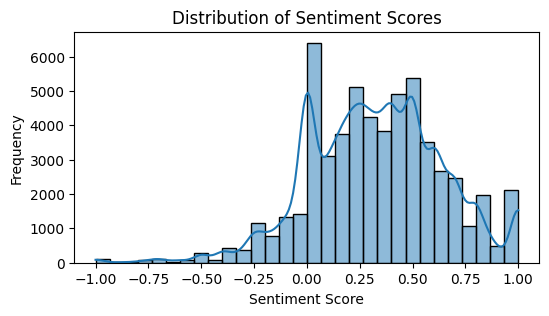

In [14]:
import seaborn as sns

# Basic sentiment scores distrubution--- most reviews are positive or neutral
plt.figure(figsize=(6, 3))
sns.histplot(data['textblob_sentiment_score'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

#### Distrubition of overall rating  --- most of the reviews are 5 stars --- significant data imbancing.... how to address???

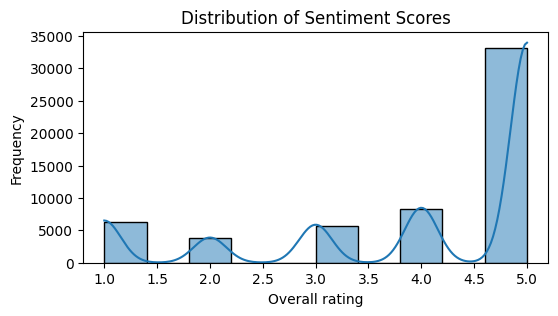

In [15]:
# distrubition of overall rating  --- most of them are 5 stars,
plt.figure(figsize=(6, 3))
sns.histplot(data['overall'], bins=10, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Overall rating')
plt.ylabel('Frequency')
plt.show()

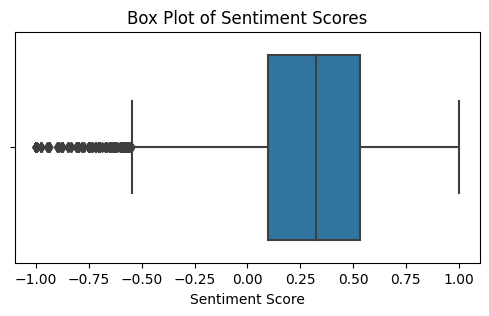

In [16]:
# Box Plot of sentiment scores
plt.figure(figsize=(6, 3))
sns.boxplot(x=data['textblob_sentiment_score'])
plt.title('Box Plot of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.show()

## 2. Define a sentiment_class column based on overall ratings

In [17]:
data.overall.unique()

array([5., 3., 4., 1., 2.])

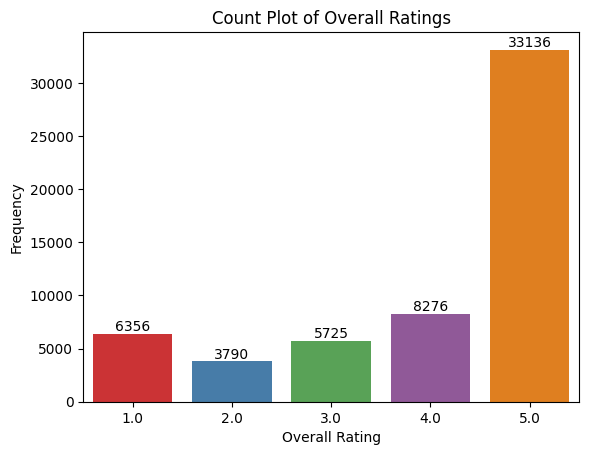

In [18]:
# Create the count plot
sns.countplot(x='overall', data=data, palette='Set1')
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()),
            ha='center', va='bottom')
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Count Plot of Overall Ratings')
plt.show()

In [19]:
# check rating 4 reviews  - decide 4 should be categorized as positive
rating_4_df = data[data['overall'] == 4]
rating_4_df.sample(5)

,overall,reviewTime,asin,reviewText,summary,title,brand,rank,category,cleaned_reviewText,textblob_sentiment_score
30622,4.0,2018-05-29,B01GGEQSWM,Soft fabric,Four Stars,Womens Nightgown Sleeveless Cotton Pajamas - S...,Floopi,160364.0,"Clothing,ShoesJewelry",soft fabric,0.100000
4528,4.0,2018-05-16,B000UJDPHQ,"Size and fit: I'm 178cm, 84kg and usually wea...",Choosing the right size is important,Alpha Industries Men's Tall Size M-65 Thigh Le...,Alpha Industries,231753.0,"Clothing,ShoesJewelry",size fit im am keg usually wear shirt size pan...,0.135431
30526,4.0,2018-09-13,B01GFVKP5M,Very cute but sparkles get everywhere...,Four Stars,CMK Trendy Kids Toddlers Fashion Purses for Li...,CMK Trendy Kids,26522.0,"Clothing,ShoesJewelry",cute sparkle get everywhere,0.500000
50791,4.0,2018-05-26,B01C85FSO2,These are nice just a little surprised how the...,Pretty nice,Odd Sox Unisex High Guys,Odd Sox,3122499.0,"Clothing,ShoesJewelry",nice little surprised stretch top still nice g...,0.318750
6232,4.0,2018-04-15,B00CQ9561G,Thin material,Four Stars,CHOCOLATE PICKLE Womens Plus Skull Rose Print ...,Chocolate Pickle,691014.0,"Clothing,ShoesJewelry",thin material,-0.400000


In [20]:
def assign_sentiment_class(rating):
    if rating <= 2.0:
        return 'Negative'
    elif rating == 3.0:
        return 'Neutral'
    else:
        return 'Positive'

data['sentiment_class'] = data['overall'].apply(assign_sentiment_class)


In [21]:
data.sample(5)

,overall,reviewTime,asin,reviewText,summary,title,brand,rank,category,cleaned_reviewText,textblob_sentiment_score,sentiment_class
9571,2.0,2018-03-21,B00KKGL3N2,They are pretty. But my piercing swelled/bubb...,Not hypoallergenic?,JewelrieShop 20G Nose Ring Hoop Stainless Stee...,NaN,14862.0,"Clothing,ShoesJewelry",pretty piercing wore something skin like,0.250000,Negative
37108,1.0,2018-06-18,B00MC4IVA8,Cheap material to tight,I would like a refund,Vintage Pleated Turban Hat - White OSFM,Jacobson Hat Company,1618931.0,"Clothing,ShoesJewelry",cheap material tight,0.110714,Negative
49247,5.0,2018-05-19,B01ALFUCZG,Bought for a buddy of mine for his b-day to go...,Good quality and shipped fast,Funny DickButt Meme Enamel Lapel Pin,MemePinz,749968.0,"Clothing,ShoesJewelry",bought buddy mine day go hat knew hed get kick...,0.450000,Positive
6051,5.0,2018-03-06,B00BCVTIAE,Nice shirt!,Five Stars,Hawaiian Tiki Panel Aloha Shirt,Pacific Legend,24152.0,"Clothing,ShoesJewelry",nice shirt !,0.750000,Positive
10081,4.0,2018-06-21,B00LP4ANKM,Comfortable and easy to wear,Four Stars,Women's Pastel Striped Lounger with Zip Front ...,Collections,1229157.0,"Clothing,ShoesJewelry",comfortable easy wear,0.416667,Positive


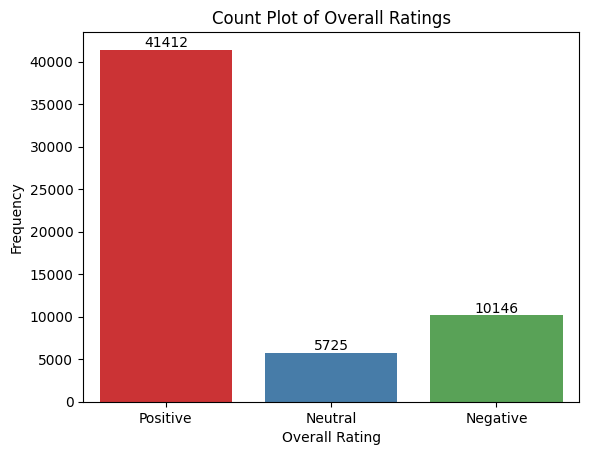

In [22]:
# count of each class
sns.countplot(x='sentiment_class', data=data, palette='Set1')
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()),
            ha='center', va='bottom')
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Count Plot of Overall Ratings')
plt.show()

## 3.Train, validation, test data preparation
1.   split data as train, validation, test datasets (75%, 15%, 10%)
2.   label encoding class labels as numerical data
        
        2: Positive; 1: Neutral;  0: Negative







In [23]:
# train, validation, test data split --- use data['sentiment_class'] as y label
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train: 75%, validation: 15%, test: 10%
x_train, x_test, y_train, y_test = train_test_split(data['cleaned_reviewText'], data['sentiment_class'], test_size=1 - train_ratio, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)


In [24]:
# check y_train
y_train[:10]

37843    Positive
38189    Negative
17041    Positive
15157    Negative
21413    Positive
29957    Positive
4346     Positive
10847    Positive
50197     Neutral
2248     Positive
Name: sentiment_class, dtype: object

In [26]:
# download train, val, test dataset for later use (bert) -- in the format of text | label

# Convert to DataFrame
train_df = pd.DataFrame({'Text': x_train, 'Label': y_train})
val_df = pd.DataFrame({'Text': x_val, 'Label': y_val})
test_df = pd.DataFrame({'Text': x_test, 'Label': y_test})
# Export to CSV with '|' as the separator
train_df.to_csv('train_data.csv', sep='|', index=False)
val_df.to_csv('validation_data.csv', sep='|', index=False)
test_df.to_csv('test_data.csv', sep='|', index=False)
print(pd.read_csv('train_data.csv', sep='|').head())

                                                Text     Label
0  perfect living literature competition well mad...  Positive
1             terrible clearly made someone basement  Negative
2  seemed like silly thing buy partner solar watc...  Positive
3  used belt daily excited belt clean look buckle...  Negative
4                                              super  Positive


In [27]:
# download train, val, test dataset for later use (bert)

from google.colab import files

files.download('train_data.csv')
files.download('validation_data.csv')
files.download('test_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
from sklearn.preprocessing import LabelEncoder

# class label encoding
label_encoder = LabelEncoder()
# Fit the label encoder and transform labels to integers
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [26]:
# check
x_train.sample(5)

10378    nice product came specter recommended quality ...
861      fit true size length quite wide discovered sho...
22550       worse item ever bought doesn't fit description
46248    leggings crazy soft comfortable second time wo...
31789                                   look cute guy live
Name: cleaned_reviewText, dtype: object

In [27]:
# check
y_train[:20]

array([2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 1])

## 4. Word Vectorization (count vector and TF-IDF) and Machine learning methods (Bayes, LR, SVM)

In [28]:
# data.info()

In [29]:
x_train.sample(10)

48019       nice wear cant stand thing around like clothes
21582    love ! actually fit higher thigh feel comforta...
30737    cute style seam waist rub bit daughter wear si...
33862                                          chain cheap
17586    love love love outfit ! ! know look good ! lao...
11112         great purse ! plenty room really blue pretty
40630    really love fit style skirt proportion right l...
16070                                        comfortable !
11245    fit excellent extremely comfortable however al...
49898    got earring gotten piercing wait month piercin...
Name: cleaned_reviewText, dtype: object

In [30]:
# x_train.isnull().sum() # 0

In [31]:
# fucntions to vectorize train, val, test text

def check_feature_names_length(vectorizer):
    '''check vectorizer's feature names length'''
    names = vectorizer.get_feature_names_out()
    print(f">>>The first 10 features names are: {names[:10]}")
    print(f">>>The length of vectorizer feature names is: {len(names)}")

def fit_and_transform(curr_vectorizer):
    vectorizer = curr_vectorizer

    train_vectors = vectorizer.fit_transform(x_train)
    check_feature_names_length(vectorizer)

    val_vectors = vectorizer.fit_transform(x_val)
    check_feature_names_length(vectorizer)

    test_vectors = vectorizer.transform(x_test)
    check_feature_names_length(vectorizer)
    return train_vectors, val_vectors, test_vectors


In [32]:
# Vectorization: Unigram + Bigram -- count and TF_IDF
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_counts = vectorizer.fit_transform(x_train)
X_val_counts = vectorizer.transform(x_val)
X_test_counts = vectorizer.transform(x_test)

# TF-IDF Transformation
tfidf_transformer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf_transformer.fit_transform(x_train)
X_val_tfidf = tfidf_transformer.transform(x_val)
X_test_tfidf = tfidf_transformer.transform(x_test)

## 4. ML models

In [33]:

classes = np.unique(y_train)

## Train and evaluate the model
def train_and_evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")
    print(classification_report(y_val, y_pred))


# Test the model
def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

    # Plotting AUROC
    # binarize the output classes for the ROC curve
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = y_test_bin.shape[1]
    # compute ROC curve and ROC area for each class
    y_score = model.predict_proba(X_test)
    # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    # Plot all ROC curves
    plt.figure()
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


#### 1) Naive Bayes

In [34]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# handle data imbalancing - using class weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))       # Create a dictionary mapping each class to its corresponding weight

Naive Bayes with Count Vectorizer
Validation Accuracy: 0.8125
              precision    recall  f1-score   support

           0       0.84      0.49      0.62      1508
           1       0.88      0.06      0.11       852
           2       0.81      0.99      0.89      6232

    accuracy                           0.81      8592
   macro avg       0.84      0.51      0.54      8592
weighted avg       0.82      0.81      0.77      8592

Test Accuracy: 0.8128818292895793
              precision    recall  f1-score   support

           0       0.84      0.51      0.63      1034
           1       0.93      0.06      0.12       572
           2       0.81      0.99      0.89      4123

    accuracy                           0.81      5729
   macro avg       0.86      0.52      0.55      5729
weighted avg       0.83      0.81      0.77      5729



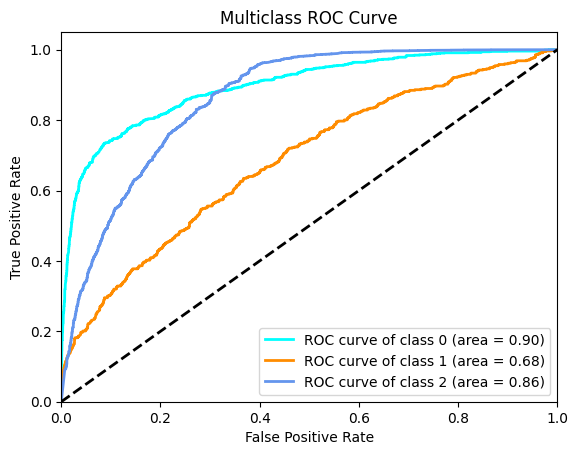

In [35]:
# Naive Bayes Model with (1,2) counter vectorizer
print("Naive Bayes with Count Vectorizer")
nb_count = MultinomialNB(class_prior=[class_weights[c] for c in classes])  # Set the class_prior parameter of the Naive Bayes classifier to the computed weights
nb_count = MultinomialNB()
train_and_evaluate_model(nb_count, X_train_counts, X_val_counts, y_train, y_val)
test_model(nb_count, X_test_counts, y_test)


Naive Bayes with TFIDF Vectorizer
Validation Accuracy: 0.7815409683426443
              precision    recall  f1-score   support

           0       0.72      0.67      0.69      1508
           1       0.24      0.31      0.27       852
           2       0.89      0.87      0.88      6232

    accuracy                           0.78      8592
   macro avg       0.62      0.62      0.62      8592
weighted avg       0.80      0.78      0.79      8592

Test Accuracy: 0.7823354861232327
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1034
           1       0.25      0.32      0.28       572
           2       0.89      0.87      0.88      4123

    accuracy                           0.78      5729
   macro avg       0.62      0.62      0.62      5729
weighted avg       0.80      0.78      0.79      5729



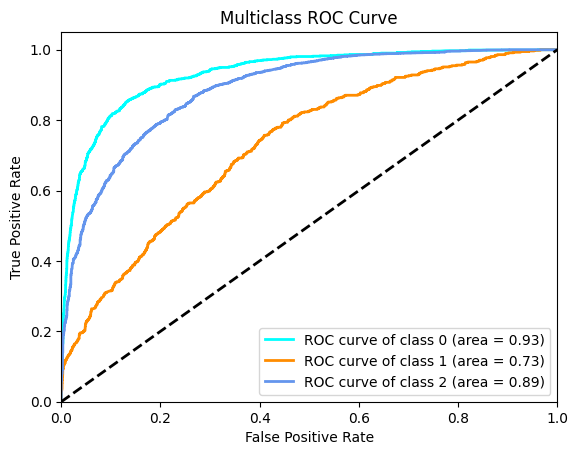

In [36]:

print("Naive Bayes with TFIDF Vectorizer")
nb_tfidf = MultinomialNB(class_prior=[class_weights[c] for c in classes])
train_and_evaluate_model(nb_tfidf, X_train_tfidf, X_val_tfidf, y_train, y_val)
test_model(nb_tfidf, X_test_tfidf, y_test)

#### 2) Logistic Regression


Logistic Regression with Count Vectorizer
Validation Accuracy: 0.827048417132216
              precision    recall  f1-score   support

           0       0.69      0.76      0.72      1508
           1       0.36      0.36      0.36       852
           2       0.93      0.91      0.92      6232

    accuracy                           0.83      8592
   macro avg       0.66      0.68      0.67      8592
weighted avg       0.83      0.83      0.83      8592

Test Accuracy: 0.8216093559085356
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      1034
           1       0.37      0.38      0.37       572
           2       0.93      0.90      0.91      4123

    accuracy                           0.82      5729
   macro avg       0.66      0.68      0.67      5729
weighted avg       0.83      0.82      0.82      5729



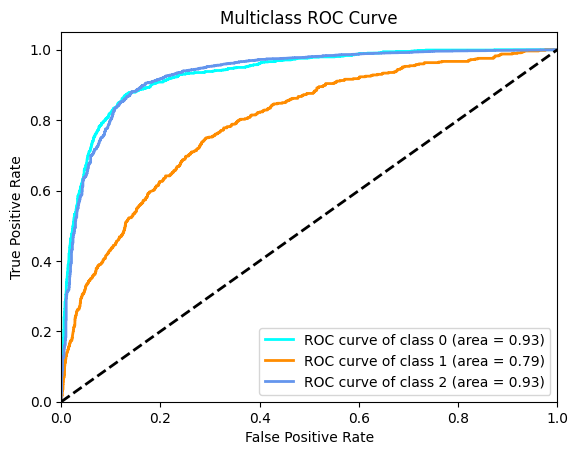

In [37]:
# Logistic Regression Model with (1,2) count vectorizer
print("\nLogistic Regression with Count Vectorizer")
lr_count = LogisticRegression(class_weight='balanced', max_iter=500)
     # automatically handle imbalancing
     # increased max_iter from 100 to 500, otherwise getting 'failed to converge' warning
train_and_evaluate_model(lr_count, X_train_counts, X_val_counts, y_train, y_val)
test_model(lr_count, X_test_counts, y_test)




Logistic Regression with TFIDF Vectorizer
Validation Accuracy: 0.8076117318435754
              precision    recall  f1-score   support

           0       0.67      0.76      0.71      1508
           1       0.32      0.43      0.37       852
           2       0.94      0.87      0.91      6232

    accuracy                           0.81      8592
   macro avg       0.65      0.69      0.66      8592
weighted avg       0.83      0.81      0.82      8592

Test Accuracy: 0.8064234595915517
              precision    recall  f1-score   support

           0       0.68      0.78      0.73      1034
           1       0.33      0.47      0.39       572
           2       0.95      0.86      0.90      4123

    accuracy                           0.81      5729
   macro avg       0.65      0.70      0.67      5729
weighted avg       0.84      0.81      0.82      5729



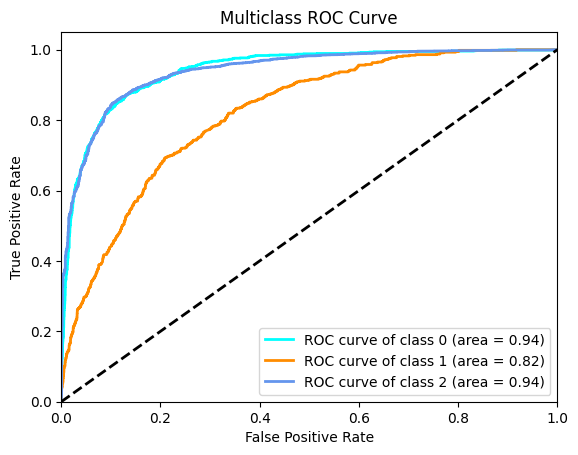

In [38]:
# # Logistic Regression Model with (1,2) tfidf vectorizer
print("\nLogistic Regression with TFIDF Vectorizer")
lr_tfidf = LogisticRegression(class_weight='balanced',  max_iter=500)   # automatically handle imbalancing
train_and_evaluate_model(lr_tfidf, X_train_tfidf, X_val_tfidf, y_train, y_val)
test_model(lr_tfidf, X_test_tfidf, y_test)

#### 3) SVM --- 暂时没跑，GPU跑了两三次都40分钟跑不出来，可能会删掉

In [ ]:
# # SVM Model with 'linear' kernel, count vectorizer -- runing more than 30 mins,
# print("\nSVM_rbf_kernel with Count Vectorizer")
# svm_count = SVC(class_weight='balanced', kernel='rbf', probability=True)   # automatically handle imbalancing
# train_and_evaluate_model(svm_count, X_train_counts, X_val_counts, y_train, y_val)
# test_model(svm_count, X_test_counts, y_test)



SVM_rbf_kernel with Count Vectorizer


In [ ]:
# #tfidf vectorizer
# print("\n")
# print("\nSVM_rbf_kernel with TFIDF Vectorizer")
# svm_tfidf = SVC(class_weight='balanced', kernel='rbf', probability=True)  # automatically hancel imbalancing
# train_and_evaluate_model(svm_tfidf, X_train_tfidf, X_val_tfidf, y_train, y_val)
# test_model(svm_tfidf, X_test_tfidf, y_test)

## 3. Deep leaning methods (RNN? LSTM? MLP? ,   Bert,  two new methods from hugging face)

## 3.0 Import DL libraries

In [39]:
# !pip install tensorflow.keras

ERROR: Could not find a version that satisfies the requirement tensorflow.keras (from versions: none)
ERROR: No matching distribution found for tensorflow.keras


In [44]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras


In [46]:
x_train.sample(5)

5816                      daughter love shoe fit true size
56956    love bag used across spain italy comfortable f...
54985    didn't realize neckline trimmed faux leather d...
31646                          bought baby brother loved !
7183     love shoe ! stylish comfortable got back trip ...
Name: cleaned_reviewText, dtype: object

## 3.1 Prepare data for DL
1.   text to sequence
    DL model embeding method: Keras's text_to_sequence with Embedding Layer
    Reason:  
    1. Large Dataset Size
    (pretrain embedings like GloVe or Word2Vec more suitable for smaler daatset)
    2. Computational Efficiency
    3. Simplicity and Flexibility
2.   padding X data (to ensure input vectors has the same length)
3.   One-hot encoding y label data (neural networks typically require this format for multiclass classification)


In [50]:
# text to sequence

tokenizer = Tokenizer()           # x_train, X_val, X_test are lists of text strings
tokenizer.fit_on_texts(x_train)   # fit on training data
# convert text strings to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(x_train)
X_val_seq = tokenizer.texts_to_sequences(x_val)
X_test_seq = tokenizer.texts_to_sequences(x_test)


# calculate vocabulary size (add 1 because indexing starts from 1)
vocab_size = len(tokenizer.word_index) + 1



In [54]:
# padding sequence data

# decide on a maximum length for sequences
max_length = max(max(len(seq) for seq in X_train_seq), max(len(seq) for seq in X_val_seq), max(len(seq) for seq in X_test_seq))

# pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')


In [57]:
# check
print(X_train_padded.shape)
print(X_val_padded.shape)
print(X_test_padded.shape)

# Long sequences -- so we didn't choose RNN, but LSTM

(42962, 537)
(8592, 537)
(5729, 537)


In [58]:
from tensorflow.keras.utils import to_categorical

# convert integer labels to one-hot encoded vectors, (neural networks typically require this format for multiclass classification.)
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

In [60]:
# check
print(y_train_one_hot.shape)
print(y_val_one_hot.shape)
print(y_test_one_hot.shape)

(42962, 3)
(8592, 3)
(5729, 3)


In [61]:
vocab_size

12863

## 3.2 LSTM

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 537)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 537, 128)          1646464   
                                                                 
 bidirectional_8 (Bidirecti  (None, 537, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1844483 (7.04 MB)
Trainable params: 1844483 (

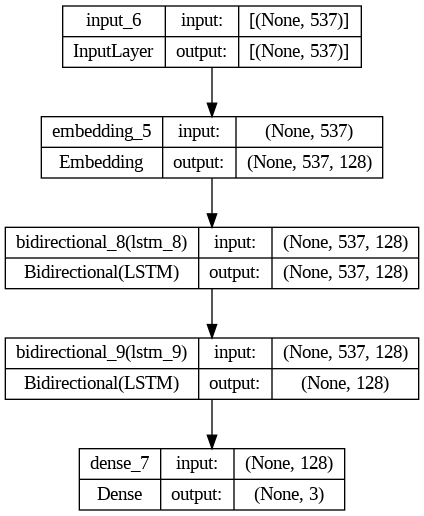

In [73]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

max_features = vocab_size  # Number of unique tokens in the vocabulary
max_sequence_length = 537  # Maximum length of sequences -- padding sequence length: 537
np.random.seed(42)
tf.random.set_seed(42)

# input layer
inputs = keras.Input(shape=(max_sequence_length,), dtype="int32")
# embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)  # First Bidirectional LSTM layer
x = layers.Bidirectional(layers.LSTM(64))(x)  # Second Bidirectional LSTM layer
# add a classifier
outputs = layers.Dense(3, activation="softmax")(x)  # we have 3 classes for classification, so use 'softmax' axtivation

# create model
model_LSTM = keras.Model(inputs=inputs, outputs=outputs)
# model summary
model_LSTM.summary()
# plot the model's structure
keras.utils.plot_model(model_LSTM, "multi_input_and_output_model.png", show_shapes=True)


In [74]:
# compile model
model_LSTM.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])  # categorical_crossentropy for multi-class classification
# fit model
model_LSTM.fit(X_train_padded, y_train_one_hot, epochs=2, batch_size=32, validation_data=(X_val_padded, y_val_one_hot))

Epoch 1/2
1343/1343 [==============================] - 145s 103ms/step - loss: 0.4804 - accuracy: 0.8156 - val_loss: 0.4237 - val_accuracy: 0.8388
Epoch 2/2
1343/1343 [==============================] - 110s 82ms/step - loss: 0.3692 - accuracy: 0.8563 - val_loss: 0.4231 - val_accuracy: 0.8372


In [77]:
# evaluate model
test_loss, test_accuracy = model_LSTM.evaluate(X_test_padded, y_test_one_hot)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


180/180 [==============================] - 6s 34ms/step - loss: 0.4293 - accuracy: 0.8330
Test Loss: 0.4293316602706909
Test Accuracy: 0.8329551219940186


In [ ]:
# epochs = [1]
# for epoch in epochs:
#   model.compile("adam", "binary_crossentropy", metrics=["accuracy"])     # optimizer: adam; loss_func: binary_crossentropy; evaluation: acc
#   history = model.fit(x_train, y_train, batch_size=32, epochs=epoch, validation_data=(x_val, y_val))
#   training_acc = history.history['accuracy'][-1]
#   validation_acc = history.history['val_accuracy'][-1]
#   print(f"When epochs is {epoch}")
#   print(f"\t train_acc is: {100 * training_acc:.2f}, validation_acc is {100 * validation_acc:.2f}\n")

## 3.2 MLP

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 537)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 537, 128)          1646464   
                                                                 
 flatten_2 (Flatten)         (None, 68736)             0         
                                                                 
 dense_11 (Dense)            (None, 64)                4399168   
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 6049987 (23.08 MB)
Trainable params: 6049987 

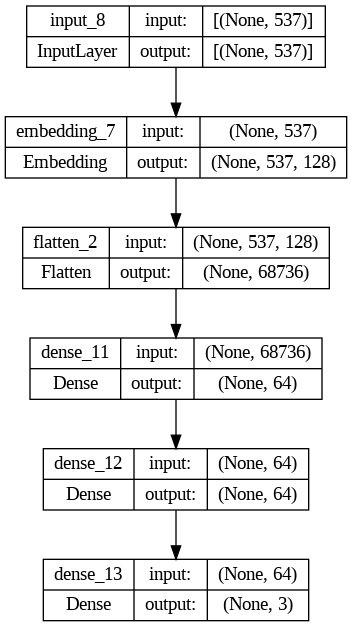

In [78]:
# input layer
inputs2 = keras.Input(shape=(max_sequence_length,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x2 = layers.Embedding(max_features, 128)(inputs2)
# flatten the 3D embedding output to 2D
x2 = layers.Flatten()(x2)
# 2 Dense layers
x2 = layers.Dense(64, activation="relu")(x2)           # choose relu, for 1.efficiency, 2. Mitigating Vanishing Gradient Problem
x2 = layers.Dense(64, activation="relu")(x2)
# output layer
outputs2 = layers.Dense(3, activation="softmax")(x2)  # 3 classes classification -- use softmax activiation


model_MLP = keras.Model(inputs=inputs2, outputs=outputs2)
model_MLP.summary()
# plot the model's structure
keras.utils.plot_model(model_MLP, "multi_input_and_output_model.png", show_shapes=True)


In [81]:
model_MLP.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_MLP.fit(X_train_padded, y_train_one_hot, epochs=2, batch_size=32, validation_data=(X_val_padded, y_val_one_hot))

Epoch 1/2
1343/1343 [==============================] - 32s 23ms/step - loss: 0.1130 - accuracy: 0.9605 - val_loss: 0.8507 - val_accuracy: 0.8244
Epoch 2/2
1343/1343 [==============================] - 10s 8ms/step - loss: 0.0975 - accuracy: 0.9666 - val_loss: 0.9374 - val_accuracy: 0.8156


In [82]:
# evaluate model
test_loss2, test_accuracy2 = model_MLP.evaluate(X_test_padded, y_test_one_hot)

# Print the results
print(f"Test Loss: {test_loss2}")
print(f"Test Accuracy: {test_accuracy2}")

180/180 [==============================] - 0s 3ms/step - loss: 0.8968 - accuracy: 0.8118
Test Loss: 0.8968155980110168
Test Accuracy: 0.8118345141410828


## 3.3 Bert

Bert need raw text data and other data preparation method


 In another ipynb.

In [ ]:
#